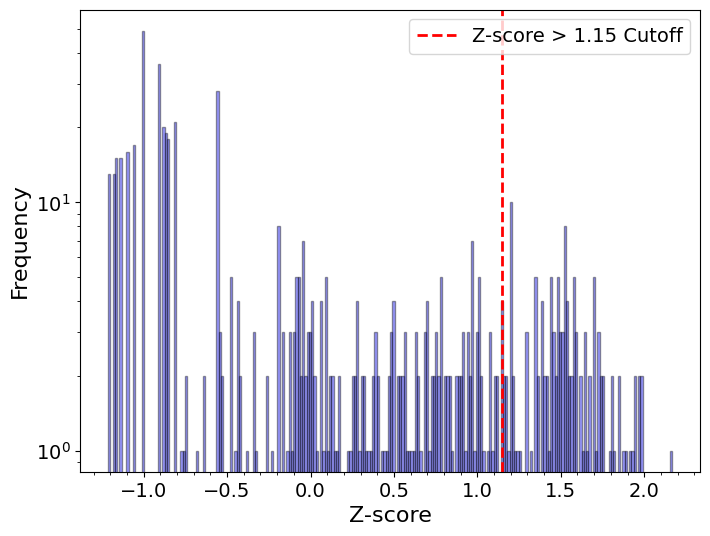

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import zscore
import os
import glob

z_score_cutoff = 1.15  # Set as appropriate
results, valid_flags, all_gene_promoters = {}, {}, set()

# Input files
input_dir = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_Counts/output_csvs'
file_paths = sorted(glob.glob(os.path.join(input_dir, 'Counts_BS*')))

# Process a single file
def process_file(path):
    df = pd.read_csv(path, skiprows=9, names=["barcode_combination", "gene_promoter", "barcode_sequence", "count"], encoding='utf-8-sig')
    df = df[df["gene_promoter"].str.startswith(("GFP_", "ilvA_", "ilvA mut 1_", "ilvA mut 2_", "ilvG_", "ilvM_", "ilvB_", "ilvN_", "ilvC_", "ilvD_")) &
            df["gene_promoter"].str.endswith(("_PGK", "_Ef1a", "_PGK-MTS", "_Ef1a-MTS"))].copy()
    df["count"] = pd.to_numeric(df["count"], errors="coerce")
    total = df["count"].sum()
    if total <= 50000:
        print(f"Skipping {path} (total_reads = {total:.0f})")
        return None, False
    df["cpm"] = df["count"] / total * 1e6
    agg = df.groupby("gene_promoter")["cpm"].sum().reset_index()
    agg["log_cpm"] = np.log10(agg["cpm"] + 1)
    agg["z_score"] = zscore(agg["log_cpm"])
    return agg, True

# Process all files
for path in file_paths:
    df, valid = process_file(path)
    results[path] = df
    valid_flags[path] = valid
    if valid and df is not None:
        all_gene_promoters.update(df["gene_promoter"])

# Build final Z-score tracking table (include all files, leave Z-scores blank for low-read samples)
rows = []
for path in file_paths:
    sample = os.path.basename(path)
    row = {"File": sample}
    df = results[path]
    for gp in sorted(all_gene_promoters):
        if valid_flags.get(path) and gp in (df["gene_promoter"].values if df is not None else []):
            row[gp] = df[df["gene_promoter"] == gp]["z_score"].values[0]
        else:
            row[gp] = np.nan
    rows.append(row)

# Save CSV
out_df = pd.DataFrame(rows)
out_df.to_csv(
    '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/CHO_Val_Zscore_Summary.csv',
    index=False
)

# Plot histogram using only valid samples
z_scores = pd.concat(
    [results[path]["z_score"] for path in file_paths if valid_flags.get(path) and results[path] is not None],
    ignore_index=True
)
plt.figure(figsize=(8, 6))
plt.hist(z_scores, bins=250, alpha=0.4, color='blue', edgecolor='black')
plt.axvline(z_score_cutoff, color='red', linestyle='--', linewidth=2, label=f"Z-score > {z_score_cutoff} Cutoff")
plt.xlabel("Z-score", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.yscale("log")
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().tick_params(axis='both', which='minor', labelsize=12)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))
plt.grid(False)
plt.legend(fontsize=14)
plt.savefig(
    '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/CHO_Val_Zscores_Summary',
    dpi=300, bbox_inches="tight"
)
plt.show()


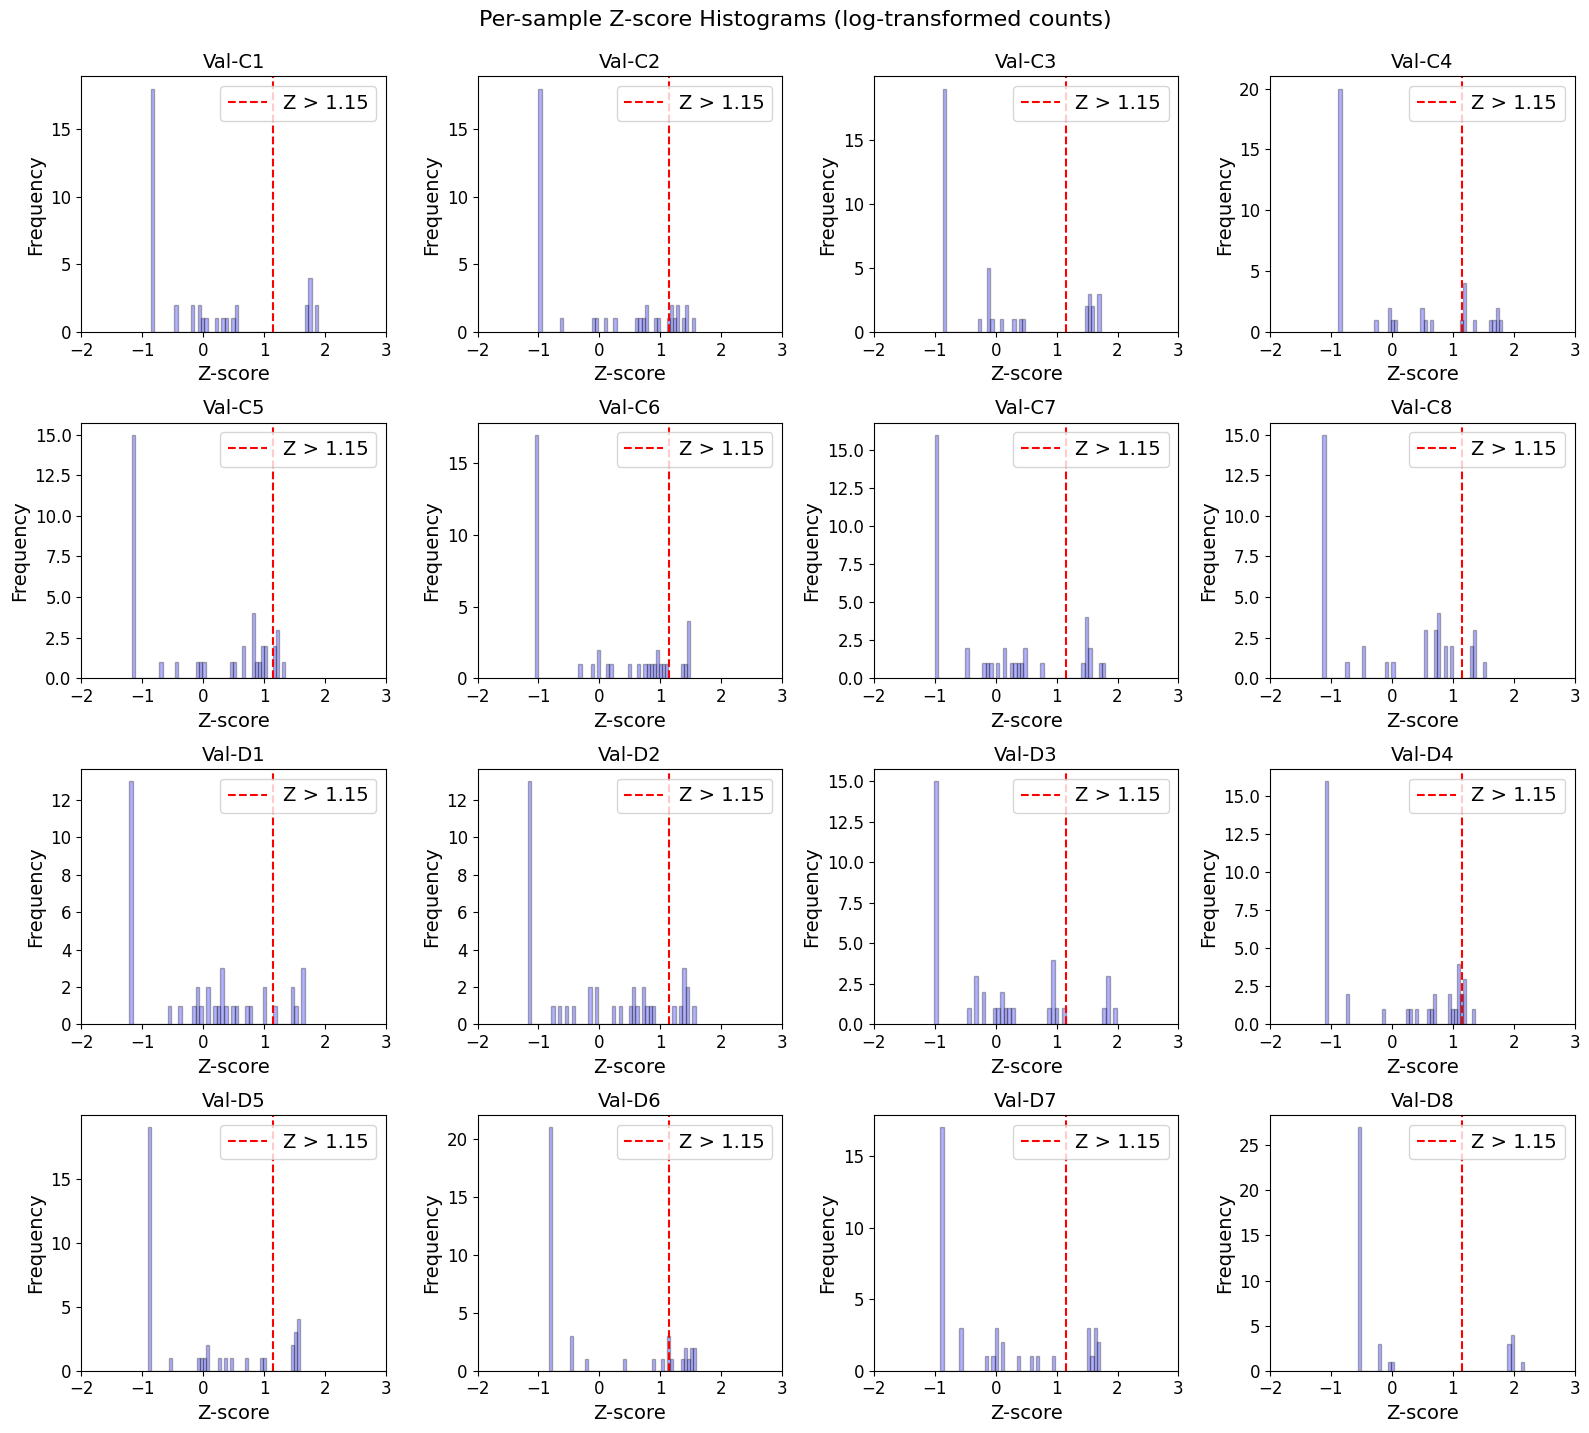

In [6]:
# Visualize per-sample Z-score distributions

import math

# Define Z-score cutoff variable
z_score_cutoff = 1.15 #set as appropriate

# Sort sample keys to maintain consistent order
sample_keys = sorted(results.keys())

# Define Subplot Titles (must be in same order as sample_keys)
subplot_titles = [
    "Val-C1", "Val-C2", "Val-C3", "Val-C4",
    "Val-C5", "Val-C6", "Val-C7", "Val-C8",
    "Val-D1", "Val-D2", "Val-D3", "Val-D4",
    "Val-D5", "Val-D6", "Val-D7", "Val-D8",
]

# Set up grid layout for plots (adjust columns as needed)
n_cols = 4
n_rows = math.ceil(len(sample_keys) / n_cols)

plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))

for i, file_path in enumerate(sample_keys):
    zscores = results[file_path]["z_score"]
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.hist(zscores, bins=50, color="blue", edgecolor="black", alpha=0.3)
    ax.axvline(z_score_cutoff, color='red', linestyle='--', label=f"Z > {z_score_cutoff}")
    ax.set_title(subplot_titles[i], fontsize=14)
    ax.set_xlim(-2, 3)
    ax.set_xlabel("Z-score", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend(fontsize=14)

    # Increase axis tick font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # Remove gridlines
    ax.grid(False)

plt.tight_layout()
plt.suptitle("Per-sample Z-score Histograms (log-transformed counts)", y=1.02, fontsize=16)
plt.savefig("/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/CHO_Valine/CHO_Valine_SummaryOutputs/CHO_Val_Zscores_Indv.png", dpi=300, bbox_inches="tight")
plt.show()
